# **NOTEBOOK2: Implementing SHAP into different blackbox models, syntehtic data**

STEP 1: generate data and clean it

In [47]:
import pandas as pd
import numpy as np


def generate_data(number_samples, number_features, noise):
    d={}
    l=[]
    f1=np.random.randn(number_samples)
    d["f1"]=f1
    for i in range(2,number_features+1):
        alpha_i= np.random.randn()
        d["f%d"%i]=alpha_i*d["f%d"%(i-1)]+noise
        l.append(alpha_i)
    df=pd.DataFrame(d)
    return (df,l)



generate_data(10,3,0.2)



(         f1        f2        f3
 0  0.438501  0.462298 -0.118843
 1  0.526145  0.514724 -0.155001
 2 -0.466191 -0.078861  0.254390
 3 -0.725457 -0.233946  0.361351
 4  0.833111  0.698342 -0.281641
 5 -1.882174 -0.925860  0.838558
 6  2.208743  1.521204 -0.849162
 7  2.204927  1.518922 -0.847588
 8 -0.679068 -0.206198  0.342213
 9  1.096331  0.855792 -0.390233,
 [0.5981702173093957, -0.6896919397024694])

In [48]:
data_tot=generate_data(150,5,0.2)
data=data_tot[0]

data.head()
data.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')


STEP 2: training a model on the data:



In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


X=data.drop(["f5"], axis=1)
y=data.f5
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
model=RandomForestRegressor(random_state=55)
model.fit(train_X,train_y)
preds=model.predict(val_X)

mae=mean_absolute_error(preds,val_y)

print(mae)

0.0055128885077270545


apply SHAP


[-0.6390133639837442, 0.8649428867539546, -1.12449557588713, -0.9143588723513751]


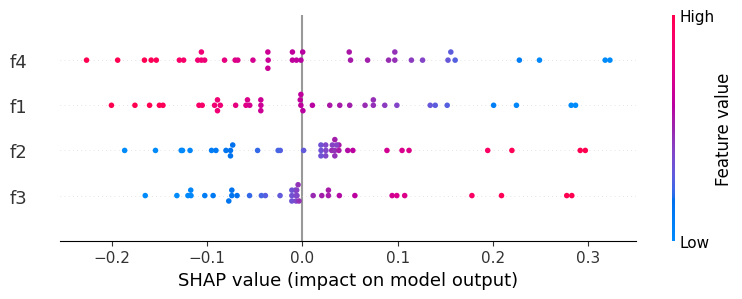

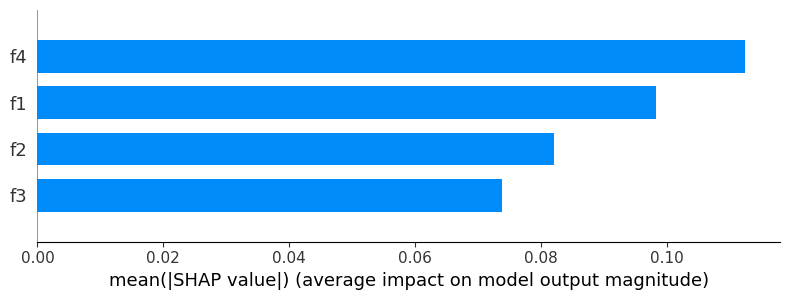

In [50]:
import shap

print(data_tot[1])

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_X)


shap.summary_plot(shap_values, val_X)


shap.summary_plot(shap_values, val_X, plot_type="bar")


shap.force_plot(explainer.expected_value, shap_values[0], val_X.iloc[0])



Test with some decorrelated data




In [51]:
d={}
l=[]
f1=np.random.randn(150)
d["f1"]=f1
for i in range(2,5+1):
    alpha_i= np.random.randn()
    d["f%d"%i]=alpha_i*d["f%d"%(i-1)]+0.2
    l.append(alpha_i)
d["f6"]=np.random.randn(150)
df=pd.DataFrame(d)

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


X=df.drop(["f5"], axis=1)
y=df.f5
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
model=RandomForestRegressor(random_state=55)
model.fit(train_X,train_y)
preds=model.predict(val_X)

mae=mean_absolute_error(preds,val_y)

print(mae)

0.0004975383562992357


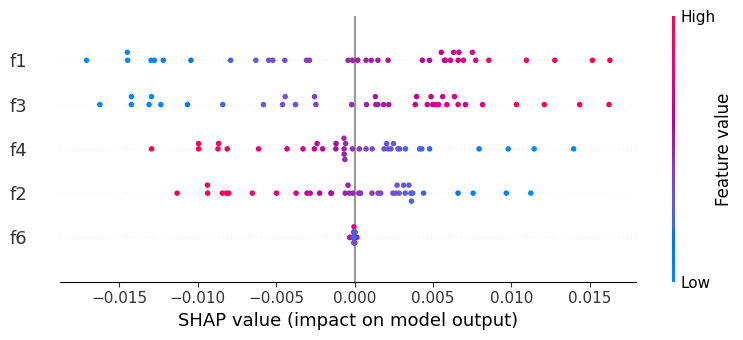

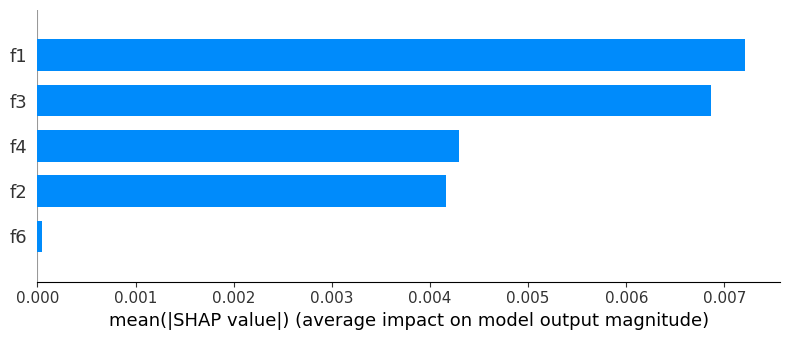

In [53]:



shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_X)


shap.summary_plot(shap_values, val_X)


shap.summary_plot(shap_values, val_X, plot_type="bar")


shap.force_plot(explainer.expected_value, shap_values[0], val_X.iloc[0])


#SHAP reconnait que f6 n'a pas eu d'importance.
maintenant, essayons de prédire f6

0.9995686308139714


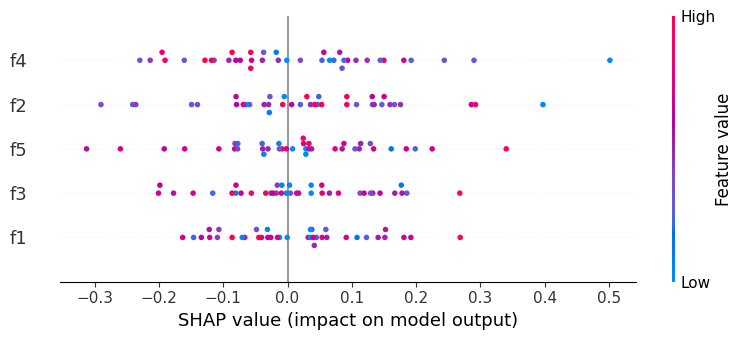

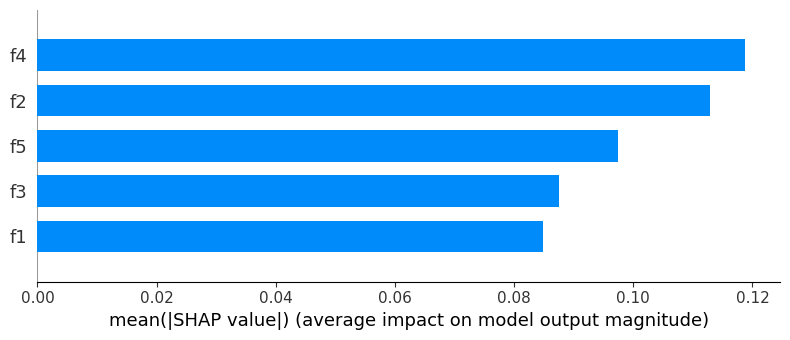

In [54]:
X=df.drop(["f6"], axis=1)
y=df.f6
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
model=RandomForestRegressor(random_state=55)
model.fit(train_X,train_y)
preds=model.predict(val_X)

mae=mean_absolute_error(preds,val_y)

print(mae)

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_X)


shap.summary_plot(shap_values, val_X)


shap.summary_plot(shap_values, val_X, plot_type="bar")


shap.force_plot(explainer.expected_value, shap_values[0], val_X.iloc[0])

shap trouve prédictions là où il n'y en a pas. testons avec plus de lignes

1.0152228368494076


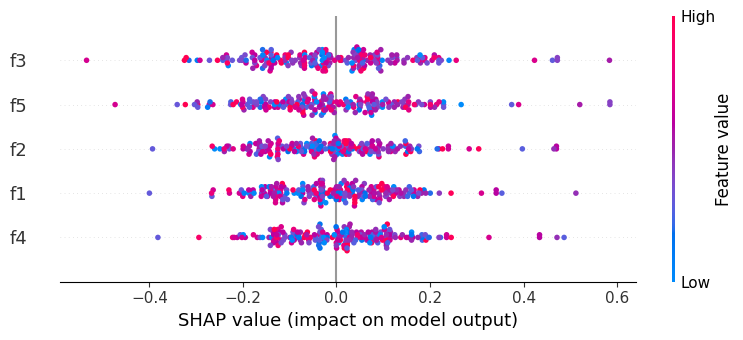

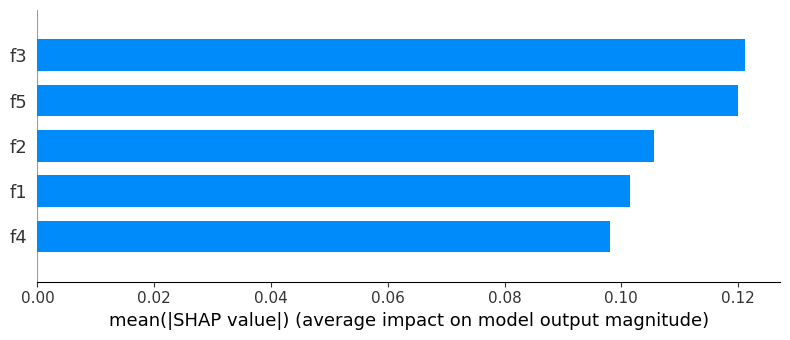

In [62]:
d={}
l=[]
f1=np.random.randn(800)
d["f1"]=f1
for i in range(2,5+1):
    alpha_i= np.random.randn()
    d["f%d"%i]=alpha_i*d["f%d"%(i-1)]+0.2
    l.append(alpha_i)
d["f6"]=np.random.randn(800)+0.2
df=pd.DataFrame(d)


X=df.drop(["f6"], axis=1)
y=df.f6
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
model=RandomForestRegressor(random_state=55)
model.fit(train_X,train_y)
preds=model.predict(val_X)

mae=mean_absolute_error(preds,val_y)

print(mae)

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_X)


shap.summary_plot(shap_values, val_X)


shap.summary_plot(shap_values, val_X, plot_type="bar")


shap.force_plot(explainer.expected_value, shap_values[0], val_X.iloc[0])

cela ne change rien. tentons les graphes de permutation

In [63]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
-0.3681 ± 0.0617,f4
-0.3811 ± 0.0354,f3
-0.3945 ± 0.0442,f1
-0.4039 ± 0.0339,f5
-0.4044 ± 0.0211,f2


c'est mieux!!! et LIME:

In [69]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(train_X.values, feature_names=train_X.columns.values.tolist(),  verbose=True, mode='regression')

exp = explainer.explain_instance(val_X.values[5], model.predict, num_features=6)

exp.show_in_notebook(show_table=True)

Intercept 0.3059637229140789
Prediction_local [0.10711211]
Right: 0.44340926163981353


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ImportError: cannot import name 'display' from 'IPython.core.display' (/opt/miniconda3/lib/python3.12/site-packages/IPython/core/display.py)